In [1]:
import numpy as np
import math
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch.multiprocessing as mp
from datetime import datetime

import pdb

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Utils
import data_generator
from model import VariationalLayer, VariationalNet

from train import TrainDecoupledElbo

In [2]:
# Setting the seeds to allow replication
# Changing the seed might require hyperparameter tuning again
# Because it changes the deterministic parameters
seed_number = 0
np.random.seed(seed_number)
torch.manual_seed(seed_number)
random.seed(seed_number)

In [3]:
is_cuda = False
dev = torch.device('cpu')  
if torch.cuda.is_available():
    is_cuda = True
    dev = torch.device('cuda')  

In [4]:
N = 10000
N_train = 6000
N_valid = N - N_train

In [5]:
X, y = data_generator.data_1to1(N)
X, y_perfect = data_generator.data_1to1(N, noise_level=1)

In [6]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [7]:
dataset = data_generator.ArtificialDataset(X, y)

data_train, data_valid = torch.utils.data.random_split(
    dataset, [N_train, N_valid])

BATCH_SIZE_LOADER = 64

training_loader = torch.utils.data.DataLoader(
    data_train, batch_size=BATCH_SIZE_LOADER,
    shuffle=False, num_workers=mp.cpu_count())

validation_loader = torch.utils.data.DataLoader(
    data_valid, batch_size=BATCH_SIZE_LOADER,
    shuffle=False, num_workers=mp.cpu_count())

In [8]:
n_samples = 20
input_size = X.shape[1]
output_size = y.shape[1]

K = 1/500
plv = 0.5

In [9]:
h = VariationalNet(n_samples, input_size, output_size, plv).to(dev)
opt_h = torch.optim.Adam(h.parameters(), lr=0.005)
mse_loss_mean = nn.MSELoss(reduction='mean')

In [10]:
train_elbo = TrainDecoupledElbo(
                model=h,
                opt=opt_h,
                loss_data=mse_loss_mean,
                K=K,
                training_loader=training_loader,
                validation_loader=validation_loader
            )

In [11]:
train_elbo.train()

------------------EPOCH 1------------------
DATA LOSS 	 train 2.03 valid 0.8
KL LOSS 	 train 4.72 valid 4.56
ELBO LOSS 	 train 6.75 valid 5.36
------------------EPOCH 2------------------
DATA LOSS 	 train 0.54 valid 0.53
KL LOSS 	 train 4.41 valid 4.26
ELBO LOSS 	 train 4.95 valid 4.79
------------------EPOCH 3------------------
DATA LOSS 	 train 0.48 valid 0.51
KL LOSS 	 train 4.09 valid 3.94
ELBO LOSS 	 train 4.57 valid 4.45
------------------EPOCH 4------------------
DATA LOSS 	 train 0.44 valid 0.45
KL LOSS 	 train 3.8 valid 3.66
ELBO LOSS 	 train 4.24 valid 4.11
------------------EPOCH 5------------------
DATA LOSS 	 train 0.39 valid 0.39
KL LOSS 	 train 3.52 valid 3.39
ELBO LOSS 	 train 3.92 valid 3.78
------------------EPOCH 6------------------
DATA LOSS 	 train 0.35 valid 0.36
KL LOSS 	 train 3.27 valid 3.15
ELBO LOSS 	 train 3.62 valid 3.51
------------------EPOCH 7------------------
DATA LOSS 	 train 0.33 valid 0.34
KL LOSS 	 train 3.04 valid 2.95
ELBO LOSS 	 train 3.37 valid

DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 1.78 valid 1.78
ELBO LOSS 	 train 2.01 valid 2.01
------------------EPOCH 59------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 1.77 valid 1.78
ELBO LOSS 	 train 2.01 valid 2.01
------------------EPOCH 60------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 1.77 valid 1.77
ELBO LOSS 	 train 2.0 valid 2.01
------------------EPOCH 61------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 1.76 valid 1.76
ELBO LOSS 	 train 1.99 valid 2.0
------------------EPOCH 62------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 1.75 valid 1.75
ELBO LOSS 	 train 1.98 valid 1.99
------------------EPOCH 63------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 1.75 valid 1.75
ELBO LOSS 	 train 1.97 valid 1.99
------------------EPOCH 64------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 1.74 valid 1.74
ELBO LOSS 	 train 1.97 valid 1.98
------------------EPOCH 65------

DATA LOSS 	 train 0.21 valid 0.23
KL LOSS 	 train 1.4 valid 1.38
ELBO LOSS 	 train 1.61 valid 1.61
------------------EPOCH 116------------------
DATA LOSS 	 train 0.21 valid 0.23
KL LOSS 	 train 1.39 valid 1.39
ELBO LOSS 	 train 1.6 valid 1.62
------------------EPOCH 117------------------
DATA LOSS 	 train 0.21 valid 0.24
KL LOSS 	 train 1.38 valid 1.38
ELBO LOSS 	 train 1.6 valid 1.62
------------------EPOCH 118------------------
DATA LOSS 	 train 0.21 valid 0.24
KL LOSS 	 train 1.38 valid 1.38
ELBO LOSS 	 train 1.59 valid 1.62
------------------EPOCH 119------------------
DATA LOSS 	 train 0.21 valid 0.23
KL LOSS 	 train 1.37 valid 1.37
ELBO LOSS 	 train 1.59 valid 1.6
------------------EPOCH 120------------------
DATA LOSS 	 train 0.21 valid 0.23
KL LOSS 	 train 1.37 valid 1.36
ELBO LOSS 	 train 1.58 valid 1.59
------------------EPOCH 121------------------
DATA LOSS 	 train 0.21 valid 0.24
KL LOSS 	 train 1.36 valid 1.35
ELBO LOSS 	 train 1.57 valid 1.59
------------------EPOCH 122-

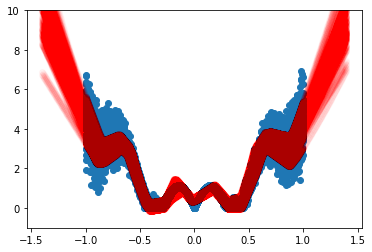

In [21]:
def plot_test_curve(X_test, y_test, h):
    xt = torch.hstack(
    (X_test[:,0], 
     torch.tensor(np.arange(-1.4, -1, 1/500), dtype = torch.float32), 
     torch.tensor(np.arange(1, 1.4, 1/500), dtype = torch.float32)))
    
    plt.scatter(X_test[:,0].detach(), y_test.detach())
    for i in range(0, 100):
        plt.scatter(xt.detach(), 
                    h(xt.unsqueeze(1)).detach().squeeze()[0], 
                    color='r', alpha=0.01)
        plt.ylim([-1, 10])
        
        
plot_test_curve(validation_loader.dataset.dataset.X,
               validation_loader.dataset.dataset.y,
               h)

In [22]:
M = 100

In [23]:
Y_pred = h(validation_loader.dataset.dataset.X[validation_loader.dataset.indices])
for i in range(1,int(M/h.n_samples)):
    Y_pred = torch.vstack((Y_pred, h(validation_loader.dataset.dataset.X[validation_loader.dataset.indices])))
    
y_test = validation_loader.dataset.dataset.y[validation_loader.dataset.indices]

In [24]:
# Demand distribution
demand_pred_distribution = Y_pred[:,:,0]
demand_true = y_test[:,0]

In [25]:
def pair_true_pred():
    idx = torch.randint(0, len(validation_loader.dataset), (1,))
    y_true_idx = demand_true[idx]
    y_pred_dist = demand_pred_distribution[:, idx]
    return y_true_idx, y_pred_dist

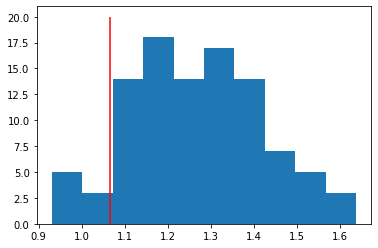

In [51]:
y_true_idx, y_pred_dist = pair_true_pred()
plt.hist(y_pred_dist.detach().numpy())
plt.vlines(y_true_idx,0, 20, color='r')

In [52]:
def profit(order, sell_price, cost_price):
    return sell_price*torch.minimum(order, demand_true) - cost_price*order

In [59]:
demand_pred_distribution.mean(axis=0).shape

torch.Size([4000])

In [64]:
sp = 200

zEypred_list = []
zypred_list = []
zy_list = []
cp_list = list(np.arange(20,190,10))
qtl_list = []

for cp in cp_list:

    # Classical newsvendor problem
    sell_price = torch.tensor(sp)
    cost_price = torch.tensor(cp)
    quantile_cut = (sell_price - cost_price)/sell_price
    optimal_pred_order = torch.quantile(demand_pred_distribution, quantile_cut, dim=0)
    optimal_order = demand_true

    zEypred = round(profit(
        demand_pred_distribution.mean(axis=0), 
        sell_price, cost_price
    ).sum().item(), 2)

    zypred = round(profit(
        optimal_pred_order, 
        sell_price, cost_price
    ).sum().item(), 2)

    zy = round(profit(
        optimal_order, 
        sell_price, cost_price
    ).sum().item(), 2)
    
    qtl_list.append(quantile_cut.item())
    
    zEypred_list.append((zy-zEypred)/zy)
    zypred_list.append((zy-zypred)/zy)

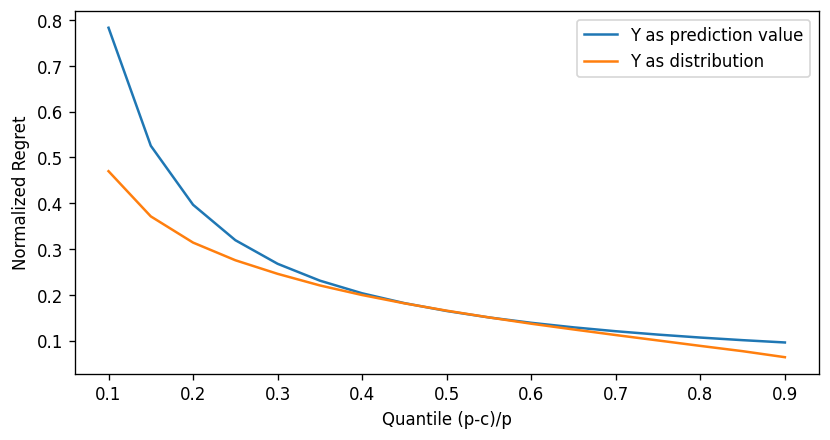

In [65]:
fig, ax = plt.subplots(figsize=(8,4), dpi=120)
ax.set_xlabel('Quantile (p-c)/p')
ax.set_ylabel('Normalized Regret')
ax.plot(qtl_list, zEypred_list, label = 'Y as prediction value')
ax.plot(qtl_list, zypred_list, label = 'Y as distribution')
ax.legend()